# 1. Adding libraries and paths

In [2]:
# This specifies the path to the directory you want to navigate to.
%cd E:\\Diploma\\Machine Learning\\AMIT Final Project

E:\Diploma\Machine Learning\AMIT Final Project


In [3]:
%clone yolov5
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
%pip install -qr requirements.txt

import os
from IPython.display import Image,clear_output
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.express as px
import glob as gb

In [4]:
print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Setup complete. Using torch 2.5.1+cu124 (NVIDIA GeForce RTX 3050 Laptop GPU)


In [2]:
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124

Looking in indexes: https://download.pytorch.org/whl/cu124
     ---------------------------------------- 0.0/2.5 GB ? eta -:--:--
     ---------------------------------------- 0.0/2.5 GB 23.5 MB/s eta 0:01:47
     ---------------------------------------- 0.0/2.5 GB 21.7 MB/s eta 0:01:56
     ---------------------------------------- 0.0/2.5 GB 20.3 MB/s eta 0:02:04
     ---------------------------------------- 0.0/2.5 GB 22.5 MB/s eta 0:01:51
     ---------------------------------------- 0.0/2.5 GB 23.7 MB/s eta 0:01:45
     ---------------------------------------- 0.0/2.5 GB 24.1 MB/s eta 0:01:44
      --------------------------------------- 0.0/2.5 GB 22.6 MB/s eta 0:01:50
      --------------------------------------- 0.0/2.5 GB 22.5 MB/s eta 0:01:51
      --------------------------------------- 0.0/2.5 GB 22.8 MB/s eta 0:01:49
      --------------------------------------- 0.0/2.5 GB 23.3 MB/s eta 0:01:46
      --------------------------------------- 0.1/2.5 GB 22.1 MB/s eta 0:01:52
 

In [5]:
%pwd

'E:\\Diploma\\Machine Learning\\AMIT Final Project'

In [6]:
dataset_path=str(os.getcwd()+'/Dataset'+'/images')

# 2. Data Preprocessing

### 2.1 Take a look into the dataset images size

In [7]:
image_size=[]
images=gb.glob(pathname=str(dataset_path+'/*.PNG'))
for img in images:
    imag=plt.imread(img)
    image_size.append(imag.shape)

pd.Series(image_size).value_counts()

(400, 301, 4)    184
(267, 400, 4)    143
(225, 400, 4)     88
(300, 400, 4)     51
(226, 400, 4)     50
                ... 
(400, 246, 4)      1
(156, 400, 4)      1
(400, 382, 4)      1
(400, 339, 4)      1
(354, 512, 3)      1
Name: count, Length: 136, dtype: int64

### 2.2 Changing The Type of Annotation Files

* The downloaded dataset has the annotations in '.xml' format. In order to train YOLO model, the annotation files should be in '.txt' format

In [1]:
import os
import xml.etree.ElementTree as ET

def convert_voc_to_yolo(xml_file, classes, output_dir):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    image_width = int(root.find('size/width').text)
    image_height = int(root.find('size/height').text)
    
    output_txt = os.path.join(output_dir, os.path.splitext(os.path.basename(xml_file))[0] + '.txt')
    with open(output_txt, 'w') as f:
        for obj in root.findall('object'):
            class_name = obj.find('name').text
            if class_name not in classes:
                continue
            class_id = classes.index(class_name)
            bndbox = obj.find('bndbox')
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)

            # Normalize coordinates
            x_center = ((xmin + xmax) / 2) / image_width
            y_center = ((ymin + ymax) / 2) / image_height
            bbox_width = (xmax - xmin) / image_width
            bbox_height = (ymax - ymin) / image_height

            # Write to YOLO format
            f.write(f"{class_id} {x_center:.6f} {y_center:.6f} {bbox_width:.6f} {bbox_height:.6f}\n")

# Example usage
classes = ['with_mask','without_mask','mask_weared_incorrect']  # Define your class list
xml_folder = r'E:\Diploma\Machine Learning\AMIT Final Project\Dataset\annotations'
output_folder = r'E:\Diploma\Machine Learning\AMIT Final Project\Dataset\Yolo Annotations'
os.makedirs(output_folder, exist_ok=True)

for xml_file in os.listdir(xml_folder):
    if xml_file.endswith('.xml'):
        convert_voc_to_yolo(os.path.join(xml_folder, xml_file), classes, output_folder)


### 2.3 Splitting the Data Into Train, Test, and Validation files

In [8]:
import os
import random
import shutil

def create_directory(path):
    """Create a directory if it doesn't exist."""
    if not os.path.exists(path):
        os.makedirs(path)

def split_dataset(image_dir, label_dir, output_dir, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1):
    # Ensure the ratios sum to 1
    assert train_ratio + val_ratio + test_ratio == 1.0, "Ratios must sum to 1."

    # Create directories for the splits
    for split in ['train', 'val', 'test']:
        create_directory(os.path.join(output_dir, split, 'images'))
        create_directory(os.path.join(output_dir, split, 'labels'))

    # Get all image files
    image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('jpg', 'jpeg', 'png'))]

    # Shuffle the image files to ensure random splitting
    random.shuffle(image_files)

    # Calculate split sizes
    total_images = len(image_files)
    train_end = int(total_images * train_ratio)
    val_end = int(total_images * (train_ratio + val_ratio))

    # Split the dataset
    train_images = image_files[:train_end]
    val_images = image_files[train_end:val_end]
    test_images = image_files[val_end:]

    # Helper function to move files
    def move_files(images, split_name):
        for image in images:
            image_path = os.path.join(image_dir, image)
            label_path = os.path.join(label_dir, os.path.splitext(image)[0] + '.txt')

            # Move image and corresponding label to the respective split folder
            if os.path.exists(label_path):  # Ensure the label exists
                shutil.copy(image_path, os.path.join(output_dir, split_name, 'images', image))
                shutil.copy(label_path, os.path.join(output_dir, split_name, 'labels', os.path.basename(label_path)))
            else:
                print(f"Warning: Label not found for image {image}. Skipping.")

    # Move files for each split
    move_files(train_images, 'train')
    move_files(val_images, 'val')
    move_files(test_images, 'test')

    print(f"Dataset split complete! Files saved in '{output_dir}'.")

# Define dataset paths 
image_directory = r'e:\Diploma\Machine Learning\AMIT Final Project\Dataset\images'  
label_directory = r'e:\Diploma\Machine Learning\AMIT Final Project\Dataset\Yolo Annotations'  
output_directory = r'e:\Diploma\Machine Learning\AMIT Final Project\Dataset\split'  

# Split the dataset
split_dataset(image_directory, label_directory, output_directory)


Dataset split complete! Files saved in 'e:\Diploma\Machine Learning\AMIT Final Project\Dataset\split'.


### 2.4 Creating The '.yaml' File

In [9]:
import os 

train_images = r'e:\Diploma\Machine Learning\AMIT Final Project\Dataset\split\train\images'
val_images = r'e:\Diploma\Machine Learning\AMIT Final Project\Dataset\split\val\images'
test_images=r'E:\Diploma\Machine Learning\AMIT Final Project\Dataset\split\test'
data_yaml_path = r'e:\Diploma\Machine Learning\AMIT Final Project\Dataset\data.yaml'

data_yamel_content=f"""
train: {train_images}
val: {val_images}
test: {test_images}

nc: 3 
names: ['with_mask','without_mask','mask_weared_incorrect']
"""

with open(data_yaml_path,'w') as file:
    file.write(data_yamel_content)

print(f'data.yaml created at {data_yaml_path}')

data.yaml created at e:\Diploma\Machine Learning\AMIT Final Project\Dataset\data.yaml


### 2.5 Checking the Annotation Files if it Created Correctly by Drawing the labels on the Images

!NOTE: the image will appear in an external window

In [32]:
import numpy as np

def draw_image_with_labels(image_path, label_path, classes):
    import cv2
    import os
    """
    Draws bounding boxes on the image based on normalized YOLO format labels.
    
    Args:
        image_path (str): Path to the image file.
        label_path (str): Path to the corresponding YOLO label file (.txt).
        classes (list): List of class names corresponding to class IDs.
    
    Returns:
        None
    """
    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not read image {image_path}")
        return
    
    # Get image dimensions
    h, w, _ = image.shape

    # Read the label file
    if not os.path.exists(label_path):
        print(f"Error: Label file {label_path} not found!")
        return

    with open(label_path, 'r') as f:
        for line in f:
            # YOLO format: class_id, x_center, y_center, bbox_width, bbox_height
            label = line.strip().split()
            class_id = int(label[0])
            x_center, y_center, bbox_width, bbox_height = map(float, label[1:])
            
            # Scale normalized coordinates to pixel values
            x_center = x_center * w
            y_center = y_center * h
            bbox_width = bbox_width * w
            bbox_height = bbox_height * h

            # Convert center coordinates to top-left and bottom-right coordinates
            x1 = int(x_center - bbox_width / 2)
            y1 = int(y_center - bbox_height / 2)
            x2 = int(x_center + bbox_width / 2)
            y2 = int(y_center + bbox_height / 2)
            
            # Draw the bounding box
            color = (0, 255, 0)  # Green
            cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
            
            # Draw the class label
            class_name = classes[class_id] if class_id < len(classes) else "Unknown"
            cv2.putText(image, class_name, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # Display the image
    cv2.imshow('Image with Labels', image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# Example Usage
image_folder = r'E:\Diploma\Machine Learning\AMIT Final Project\Dataset\images'
label_folder = r'E:\Diploma\Machine Learning\AMIT Final Project\Dataset\Yolo Annotations'
classes = ['with_mask','without_mask','mask_weared_incorrect']  # Update this with your class names

# get image and draw labels
image_file=os.listdir(image_folder)
random_number=np.random.randint(0,len(image_file))

if image_file[random_number].endswith(('.jpg', '.png', '.jpeg')):  # Add other extensions as needed
    image_path = os.path.join(image_folder, image_file[random_number])
    label_path = os.path.join(label_folder, os.path.splitext(image_file[random_number])[0] + '.txt')
    draw_image_with_labels(image_path, label_path, classes)


#### 2.6 Looking into the balancing of classes

c:\Users\ah-ma\anaconda3\lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


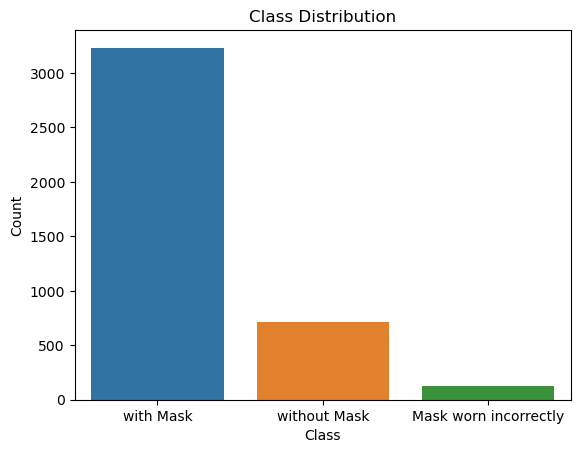

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

label_folder=r'E:\Diploma\Machine Learning\AMIT Final Project\Dataset\Yolo Annotations'

with_mask=0
without_mask=0
incorrect_mask=0

for file_name in os.listdir(label_folder):
    file_path = os.path.join(label_folder, file_name)  
    if os.path.isfile(file_path):  
        with open(file_path, 'r') as file:
            for line in file:
                label = line.strip().split()
                if label[0] == '0':
                    with_mask += 1
                elif label[0] == '1':
                    without_mask += 1
                elif label[0] == '2':
                    incorrect_mask += 1

classes={'with Mask':with_mask,'without Mask':without_mask,'Mask worn incorrectly':incorrect_mask}

sns.barplot(x=list(classes.keys()),y=list(classes.values()))
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

# 3 Trining YOLO Models

### 3.1 Train a YOLOv5 Model

In [7]:
from ultralytics import YOLO

# Path to your .yaml file
data_yaml_path = r'e:\Diploma\Machine Learning\AMIT Final Project\Dataset\data.yaml'  # Update this path if necessary

# Train YOLOv5 model
model = YOLO('yolov5s.pt')  # You can use 'yolov5m.pt', 'yolov5l.pt', etc.
model.train(
    data=data_yaml_path,
    epochs=50,             # Number of epochs
    batch=16,              # Batch size
    imgsz=768,             # Image size
    project=r'e:\Diploma\Machine Learning\AMIT Final Project\Dataset',  # Save results in this folder
    name='Results4_V5',            # Experiment name
    device=0,
    lr0=0.001,
    exist_ok=True          # Overwrite previous results
)


PRO TIP  Replace 'model=yolov5s.pt' with new 'model=yolov5su.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.

New https://pypi.org/project/ultralytics/8.3.49 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.48  Python-3.9.12 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: task=detect, mode=train, model=yolov5s.pt, data=e:\Diploma\Machine Learning\AMIT Final Project\Dataset\data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=768, save=True, save_period=-1, cache=False, device=0, workers=8, project=e:\Diploma\Machine Learning\AMIT Final Project\Dataset, name=Results4, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=N

train: Scanning E:\Diploma\Machine Learning\AMIT Final Project\Dataset\split\train\labels... 682 images, 0 backgrounds, 0 corrupt: 100%|██████████| 682/682 [00:01<00:00, 365.11it/s]

train: New cache created: E:\Diploma\Machine Learning\AMIT Final Project\Dataset\split\train\labels.cache



val: Scanning E:\Diploma\Machine Learning\AMIT Final Project\Dataset\split\val\labels.cache... 85 images, 0 backgrounds, 0 corrupt: 100%|██████████| 85/85 [00:00<?, ?it/s]


Plotting labels to e:\Diploma\Machine Learning\AMIT Final Project\Dataset\Results4\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 69 weight(decay=0.0), 76 weight(decay=0.0005), 75 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 768 train, 768 val
Using 8 dataloader workers
Logging results to e:\Diploma\Machine Learning\AMIT Final Project\Dataset\Results4
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      6.09G      1.618      2.326      1.465         53        768: 100%|██████████| 43/43 [06:13<00:00,  8.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:23<00:00,  7.73s/it]

                   all         85        418      0.507      0.427      0.483      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      5.99G       1.27      1.084       1.14         69        768: 100%|██████████| 43/43 [05:14<00:00,  7.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:18<00:00,  6.02s/it]

                   all         85        418      0.802      0.466      0.511      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      6.08G       1.22     0.9977      1.122         73        768: 100%|██████████| 43/43 [05:18<00:00,  7.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:20<00:00,  6.98s/it]

                   all         85        418      0.494      0.532      0.514      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      6.01G      1.228      0.864      1.114         61        768: 100%|██████████| 43/43 [04:08<00:00,  5.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:10<00:00,  3.55s/it]

                   all         85        418      0.461      0.539      0.529      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      5.93G        1.2     0.8079      1.103        106        768: 100%|██████████| 43/43 [04:45<00:00,  6.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:24<00:00,  8.13s/it]

                   all         85        418      0.768      0.546      0.651      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      6.02G      1.183      0.786      1.098         90        768: 100%|██████████| 43/43 [05:49<00:00,  8.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:17<00:00,  5.93s/it]

                   all         85        418      0.549      0.656       0.62      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      6.04G      1.178     0.7689      1.093         73        768: 100%|██████████| 43/43 [06:09<00:00,  8.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:20<00:00,  6.76s/it]

                   all         85        418      0.551      0.685      0.631      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      5.96G      1.141     0.7462      1.071         99        768: 100%|██████████| 43/43 [04:44<00:00,  6.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:18<00:00,  6.11s/it]

                   all         85        418      0.572      0.734      0.688      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      6.02G      1.123     0.7083      1.065        106        768: 100%|██████████| 43/43 [05:08<00:00,  7.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:16<00:00,  5.62s/it]

                   all         85        418      0.612      0.736      0.762       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      6.05G      1.119     0.6947      1.056         70        768: 100%|██████████| 43/43 [06:14<00:00,  8.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:17<00:00,  5.91s/it]

                   all         85        418      0.739      0.631      0.718      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      6.03G      1.117     0.6941      1.064         45        768: 100%|██████████| 43/43 [08:10<00:00, 11.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:27<00:00,  9.25s/it]

                   all         85        418      0.623      0.672      0.668      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      6.05G      1.092     0.6487      1.041         63        768: 100%|██████████| 43/43 [07:31<00:00, 10.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:19<00:00,  6.60s/it]

                   all         85        418      0.597      0.656      0.629      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      6.01G      1.093     0.6562      1.045         57        768: 100%|██████████| 43/43 [05:27<00:00,  7.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:17<00:00,  5.89s/it]

                   all         85        418      0.751      0.655      0.745      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      6.27G      1.085     0.6383      1.042         56        768: 100%|██████████| 43/43 [04:13<00:00,  5.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.43s/it]

                   all         85        418      0.586      0.727      0.667      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      5.97G      1.069     0.6277      1.041         53        768: 100%|██████████| 43/43 [04:51<00:00,  6.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:17<00:00,  5.82s/it]

                   all         85        418      0.765      0.639      0.694      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      6.06G      1.057     0.6122      1.024        102        768: 100%|██████████| 43/43 [04:22<00:00,  6.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:12<00:00,  4.10s/it]

                   all         85        418      0.726      0.648        0.7      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      5.95G      1.044     0.6012      1.026        135        768: 100%|██████████| 43/43 [04:36<00:00,  6.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:16<00:00,  5.53s/it]

                   all         85        418      0.715      0.594      0.704      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      6.07G       1.04     0.5994       1.02         69        768: 100%|██████████| 43/43 [04:00<00:00,  5.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:12<00:00,  4.25s/it]

                   all         85        418      0.693      0.627      0.706      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      6.39G      1.043     0.5958      1.013         66        768: 100%|██████████| 43/43 [04:48<00:00,  6.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.91s/it]

                   all         85        418      0.672      0.663      0.668       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      5.95G      1.009     0.5745      1.005        126        768: 100%|██████████| 43/43 [04:37<00:00,  6.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:11<00:00,  3.78s/it]

                   all         85        418      0.854      0.627      0.751        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      5.96G      1.038     0.5716      1.009         68        768: 100%|██████████| 43/43 [05:00<00:00,  6.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.78s/it]

                   all         85        418      0.672      0.692      0.687      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      6.05G      1.017     0.5626      1.008         69        768: 100%|██████████| 43/43 [04:46<00:00,  6.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:11<00:00,  3.93s/it]

                   all         85        418      0.784      0.643      0.724      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      6.05G      1.017     0.5576      1.002         43        768: 100%|██████████| 43/43 [04:59<00:00,  6.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:17<00:00,  5.77s/it]

                   all         85        418      0.597      0.707      0.704      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      6.03G     0.9939     0.5419      1.003         60        768: 100%|██████████| 43/43 [05:03<00:00,  7.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:11<00:00,  3.78s/it]

                   all         85        418       0.73      0.706      0.736      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50       5.9G      1.016     0.5467          1         58        768: 100%|██████████| 43/43 [04:19<00:00,  6.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:16<00:00,  5.62s/it]

                   all         85        418      0.626      0.752      0.721      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      5.96G      1.018     0.5501     0.9929        115        768: 100%|██████████| 43/43 [04:52<00:00,  6.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.37s/it]

                   all         85        418      0.693      0.738      0.748      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      6.04G      1.023      0.536     0.9994         76        768: 100%|██████████| 43/43 [04:39<00:00,  6.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:17<00:00,  5.71s/it]

                   all         85        418      0.734       0.69      0.739      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      5.95G     0.9675      0.512     0.9829         75        768: 100%|██████████| 43/43 [04:24<00:00,  6.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.69s/it]

                   all         85        418      0.677      0.721      0.729      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      5.95G     0.9941      0.525      0.982        190        768: 100%|██████████| 43/43 [04:27<00:00,  6.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:17<00:00,  5.73s/it]

                   all         85        418      0.748      0.718      0.754      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      6.38G     0.9704     0.5088     0.9756         89        768: 100%|██████████| 43/43 [04:40<00:00,  6.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.99s/it]

                   all         85        418      0.734      0.806      0.765      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      6.06G     0.9485     0.5038     0.9826         57        768: 100%|██████████| 43/43 [04:39<00:00,  6.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:18<00:00,  6.22s/it]

                   all         85        418      0.777      0.665      0.731      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      6.05G     0.9519        0.5     0.9711         92        768: 100%|██████████| 43/43 [04:57<00:00,  6.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:10<00:00,  3.66s/it]

                   all         85        418      0.694      0.731      0.729      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      5.94G     0.9529     0.5009     0.9685        106        768: 100%|██████████| 43/43 [04:29<00:00,  6.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:17<00:00,  5.98s/it]

                   all         85        418      0.749      0.667      0.744      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      5.94G     0.9257     0.4863     0.9693        123        768: 100%|██████████| 43/43 [04:23<00:00,  6.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:15<00:00,  5.14s/it]

                   all         85        418      0.819      0.651      0.721      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      6.79G     0.9258      0.485     0.9577         95        768: 100%|██████████| 43/43 [05:08<00:00,  7.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:12<00:00,  4.32s/it]

                   all         85        418      0.735      0.686      0.729        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      5.94G     0.9222     0.4783     0.9588         75        768: 100%|██████████| 43/43 [04:46<00:00,  6.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:15<00:00,  5.31s/it]

                   all         85        418      0.798      0.647      0.745      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      6.05G     0.9171     0.4785     0.9629        124        768: 100%|██████████| 43/43 [05:17<00:00,  7.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:16<00:00,  5.45s/it]

                   all         85        418      0.845      0.645      0.769      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      5.98G     0.8841     0.4606     0.9549        160        768: 100%|██████████| 43/43 [05:13<00:00,  7.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:15<00:00,  5.27s/it]

                   all         85        418      0.781      0.735      0.754      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      5.95G     0.8933     0.4609     0.9608         93        768: 100%|██████████| 43/43 [04:29<00:00,  6.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:18<00:00,  6.31s/it]

                   all         85        418      0.777       0.66      0.739      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      5.94G     0.8892     0.4513     0.9429         96        768: 100%|██████████| 43/43 [04:58<00:00,  6.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:17<00:00,  5.99s/it]

                   all         85        418      0.753      0.737       0.75       0.51


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      6.04G     0.8957     0.4415     0.9502         42        768: 100%|██████████| 43/43 [03:22<00:00,  4.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:16<00:00,  5.53s/it]

                   all         85        418       0.67      0.758      0.767      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      6.02G     0.8656     0.4257     0.9447         43        768: 100%|██████████| 43/43 [03:36<00:00,  5.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:12<00:00,  4.01s/it]

                   all         85        418      0.707      0.734      0.733      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50         6G     0.8572     0.4178     0.9302         33        768: 100%|██████████| 43/43 [04:56<00:00,  6.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:17<00:00,  5.81s/it]

                   all         85        418      0.754       0.67       0.73      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      6.01G     0.8567     0.4099       0.94         33        768: 100%|██████████| 43/43 [04:32<00:00,  6.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:11<00:00,  3.68s/it]

                   all         85        418      0.771      0.732      0.751      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      5.95G     0.8375     0.4028     0.9264         29        768: 100%|██████████| 43/43 [04:18<00:00,  6.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:17<00:00,  5.71s/it]

                   all         85        418      0.719      0.731      0.737      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      6.08G     0.8363      0.398     0.9272         42        768: 100%|██████████| 43/43 [03:57<00:00,  5.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.90s/it]

                   all         85        418      0.794      0.722      0.757      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      6.04G      0.821     0.3971     0.9247         17        768: 100%|██████████| 43/43 [05:07<00:00,  7.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:17<00:00,  5.70s/it]

                   all         85        418      0.653      0.748      0.741      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      5.85G     0.8069     0.3874     0.9237         54        768: 100%|██████████| 43/43 [03:55<00:00,  5.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:11<00:00,  3.94s/it]

                   all         85        418      0.691      0.731      0.726      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      6.05G     0.8047     0.3824     0.9137         57        768: 100%|██████████| 43/43 [03:46<00:00,  5.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:15<00:00,  5.26s/it]

                   all         85        418      0.785      0.718      0.739       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      6.05G     0.8019     0.3752     0.9156         20        768: 100%|██████████| 43/43 [04:27<00:00,  6.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:11<00:00,  3.75s/it]

                   all         85        418      0.763      0.722      0.742      0.511



50 epochs completed in 4.348 hours.
Optimizer stripped from e:\Diploma\Machine Learning\AMIT Final Project\Dataset\Results4\weights\last.pt, 18.5MB
Optimizer stripped from e:\Diploma\Machine Learning\AMIT Final Project\Dataset\Results4\weights\best.pt, 18.5MB

Validating e:\Diploma\Machine Learning\AMIT Final Project\Dataset\Results4\weights\best.pt...
Ultralytics 8.3.48  Python-3.9.12 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLOv5s summary (fused): 193 layers, 9,112,697 parameters, 0 gradients, 23.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:06<00:00,  2.13s/it]


                   all         85        418      0.845      0.645      0.768      0.524
             with_mask         72        316      0.952      0.861      0.958      0.681
          without_mask         36         95      0.951      0.789      0.921      0.606
 mask_weared_incorrect          7          7      0.632      0.286      0.426      0.285
Speed: 2.4ms preprocess, 63.5ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to e:\Diploma\Machine Learning\AMIT Final Project\Dataset\Results4


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000016D6F4728E0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          

#### 3.1.1 Prediction of YOLOv5

In [34]:
from ultralytics import YOLO 
import cv2
import os

# Load the trained YOLO model
model1_path = r'E:\Diploma\Machine Learning\AMIT Final Project\Dataset\Results4_V5\weights\best.pt'  

# Path to the image for prediction
input_path1 = r'E:\Diploma\Machine Learning\AMIT Final Project\Dataset\split\test\images'  
output_path1 = r'E:\Diploma\Machine Learning\AMIT Final Project\Dataset\Test Prediction Files\PredictionsV5'  # Folder to save predictions
os.makedirs(output_path1, exist_ok=True)

# Make predictions
mode1 = YOLO(model1_path)
results1 = model.predict(source=input_path1, save=True,conf=0.5, save_dir=output_path1)

# Saving the predicted images in output_path file
for result in results1:
    annotated_image = result.plot()
    output_file = os.path.join(output_path1, f"annotated_{os.path.basename(result.path)}")
    cv2.imwrite(output_file, annotated_image)
    print(f"Saved: {output_file}") 


image 1/87 E:\Diploma\Machine Learning\AMIT Final Project\Dataset\split\test\images\maksssksksss10.png: 768x608 1 with_mask, 270.5ms
image 2/87 E:\Diploma\Machine Learning\AMIT Final Project\Dataset\split\test\images\maksssksksss104.png: 544x768 2 with_masks, 6 without_masks, 32.0ms
image 3/87 E:\Diploma\Machine Learning\AMIT Final Project\Dataset\split\test\images\maksssksksss108.png: 448x768 4 with_masks, 1 without_mask, 30.0ms
image 4/87 E:\Diploma\Machine Learning\AMIT Final Project\Dataset\split\test\images\maksssksksss111.png: 544x768 8 with_masks, 1 without_mask, 33.0ms
image 5/87 E:\Diploma\Machine Learning\AMIT Final Project\Dataset\split\test\images\maksssksksss118.png: 544x768 2 with_masks, 28.0ms
image 6/87 E:\Diploma\Machine Learning\AMIT Final Project\Dataset\split\test\images\maksssksksss136.png: 768x544 1 with_mask, 32.0ms
image 7/87 E:\Diploma\Machine Learning\AMIT Final Project\Dataset\split\test\images\maksssksksss145.png: 448x768 2 without_masks, 2 mask_weared_inco

### 3.2 Train a YOLOv8n Model

In [4]:
from ultralytics import YOLO

# Path to your .yaml file
data_yaml_path = r'e:\Diploma\Machine Learning\AMIT Final Project\Dataset\data.yaml' 

# Train YOLOv5 model
model2 = YOLO('yolov8n.pt')  # You can use 'yolov5m.pt', 'yolov5l.pt', etc.
model2.train(
    data=data_yaml_path,
    epochs=50,             # Number of epochs
    batch=16,              # Batch size
    imgsz=768,             # Image size
    project=r'e:\Diploma\Machine Learning\AMIT Final Project\Dataset',  # Save results in this folder
    name='Results5_V8n',            # Experiment name
    device=0,
    exist_ok=True          # Overwrite previous results
)

100%|██████████| 6.25M/6.25M [00:00<00:00, 12.2MB/s]


New https://pypi.org/project/ultralytics/8.3.50 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.48  Python-3.9.12 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=e:\Diploma\Machine Learning\AMIT Final Project\Dataset\data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=768, save=True, save_period=-1, cache=False, device=0, workers=8, project=e:\Diploma\Machine Learning\AMIT Final Project\Dataset, name=Results5_V8, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=

train: Scanning E:\Diploma\Machine Learning\AMIT Final Project\Dataset\split\train\labels.cache... 682 images, 0 backgrounds, 0 corrupt: 100%|██████████| 682/682 [00:00<?, ?it/s]
val: Scanning E:\Diploma\Machine Learning\AMIT Final Project\Dataset\split\val\labels.cache... 85 images, 0 backgrounds, 0 corrupt: 100%|██████████| 85/85 [00:00<?, ?it/s]


Plotting labels to e:\Diploma\Machine Learning\AMIT Final Project\Dataset\Results5_V8\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 768 train, 768 val
Using 8 dataloader workers
Logging results to e:\Diploma\Machine Learning\AMIT Final Project\Dataset\Results5_V8
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      3.46G      1.666      2.736      1.415         53        768: 100%|██████████| 43/43 [00:16<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.86it/s]

                   all         85        418     0.0156      0.596      0.245      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      3.95G      1.326      1.462      1.095         69        768: 100%|██████████| 43/43 [00:15<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.32it/s]

                   all         85        418      0.494      0.393      0.418      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      3.87G      1.251      1.286      1.079         73        768: 100%|██████████| 43/43 [00:16<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.69it/s]

                   all         85        418      0.422      0.428      0.455      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      3.43G      1.252      1.155      1.072         61        768: 100%|██████████| 43/43 [00:12<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.11it/s]

                   all         85        418      0.506      0.573      0.562      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50       3.8G      1.208      1.057      1.052        106        768: 100%|██████████| 43/43 [00:14<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.58it/s]

                   all         85        418      0.885      0.486      0.584      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      3.75G      1.192     0.9885      1.055         90        768: 100%|██████████| 43/43 [00:13<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.81it/s]

                   all         85        418       0.55      0.539      0.556      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      3.55G      1.196     0.9217       1.05         73        768: 100%|██████████| 43/43 [00:13<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.21it/s]

                   all         85        418      0.575      0.491       0.56      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      3.74G      1.145     0.8771      1.027         99        768: 100%|██████████| 43/43 [00:16<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]

                   all         85        418      0.592      0.597      0.614      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      3.56G      1.128     0.8229      1.023        106        768: 100%|██████████| 43/43 [00:13<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.25it/s]

                   all         85        418      0.909      0.481       0.57      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      3.48G      1.122     0.7937      1.018         70        768: 100%|██████████| 43/43 [00:13<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.24it/s]

                   all         85        418      0.742      0.517      0.631      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      3.66G      1.112     0.7979       1.02         45        768: 100%|██████████| 43/43 [00:14<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.48it/s]

                   all         85        418      0.893      0.538      0.646      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      3.28G      1.093     0.7493      1.007         63        768: 100%|██████████| 43/43 [00:13<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.24it/s]

                   all         85        418      0.552      0.539      0.587       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      3.44G      1.094     0.7399      1.005         57        768: 100%|██████████| 43/43 [00:13<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.30it/s]

                   all         85        418      0.627      0.623      0.647      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50       3.8G      1.083     0.7094      1.001         56        768: 100%|██████████| 43/43 [00:14<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.55it/s]

                   all         85        418      0.834      0.613      0.711      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      3.39G      1.074     0.6887      1.005         53        768: 100%|██████████| 43/43 [00:13<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.40it/s]

                   all         85        418      0.761      0.588      0.687      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      3.58G       1.06     0.6708     0.9976        102        768: 100%|██████████| 43/43 [00:13<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.66it/s]

                   all         85        418      0.789      0.614      0.687      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      4.04G      1.042     0.6544     0.9925        135        768: 100%|██████████| 43/43 [00:15<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.83it/s]

                   all         85        418      0.707       0.62       0.64      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      3.45G      1.056     0.6519     0.9931         69        768: 100%|██████████| 43/43 [00:13<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.72it/s]

                   all         85        418      0.775      0.606      0.711      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      3.76G      1.058     0.6485     0.9861         66        768: 100%|██████████| 43/43 [00:31<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.77it/s]

                   all         85        418      0.933       0.63      0.699      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      3.43G      1.018     0.6237     0.9822        126        768: 100%|██████████| 43/43 [00:13<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.18it/s]

                   all         85        418      0.688      0.605      0.688      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      3.49G      1.039     0.6148     0.9807         68        768: 100%|██████████| 43/43 [00:13<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.95it/s]

                   all         85        418       0.75      0.604      0.658      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      3.41G      1.023     0.6197     0.9843         69        768: 100%|██████████| 43/43 [00:13<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.00it/s]

                   all         85        418      0.708       0.71      0.707      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      3.87G      1.028     0.6061     0.9793         43        768: 100%|██████████| 43/43 [00:16<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.29it/s]

                   all         85        418       0.71      0.702      0.673      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      3.55G       1.02     0.5925     0.9829         60        768: 100%|██████████| 43/43 [00:13<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.13it/s]

                   all         85        418      0.733      0.586       0.68      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50       3.4G      1.032     0.5955     0.9787         58        768: 100%|██████████| 43/43 [00:13<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.05it/s]

                   all         85        418       0.67      0.584      0.677      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      4.16G      1.024     0.6009     0.9651        115        768: 100%|██████████| 43/43 [00:17<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.49it/s]

                   all         85        418      0.738      0.581      0.662      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      3.81G      1.033     0.5851      0.974         76        768: 100%|██████████| 43/43 [00:19<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.33it/s]

                   all         85        418      0.604      0.687      0.687      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50       3.7G     0.9765     0.5542     0.9613         75        768: 100%|██████████| 43/43 [00:14<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.74it/s]

                   all         85        418      0.687      0.654       0.68      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      3.69G      1.011     0.5669     0.9652        190        768: 100%|██████████| 43/43 [00:14<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.66it/s]

                   all         85        418      0.929      0.626      0.717      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50         4G     0.9852     0.5535     0.9593         89        768: 100%|██████████| 43/43 [00:16<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]

                   all         85        418      0.639      0.677      0.678      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      3.64G     0.9628     0.5433     0.9632         57        768: 100%|██████████| 43/43 [00:13<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.18it/s]

                   all         85        418      0.643      0.673      0.679      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50       3.8G     0.9703     0.5424     0.9543         92        768: 100%|██████████| 43/43 [00:14<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.01it/s]

                   all         85        418      0.714      0.574      0.681      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      3.77G     0.9819     0.5464     0.9579        106        768: 100%|██████████| 43/43 [00:17<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.95it/s]

                   all         85        418      0.663      0.661      0.703       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      3.36G     0.9462     0.5246     0.9487        123        768: 100%|██████████| 43/43 [00:13<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.16it/s]

                   all         85        418       0.87      0.637      0.719      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      4.15G     0.9414      0.519     0.9385         95        768: 100%|██████████| 43/43 [00:17<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.60it/s]

                   all         85        418      0.836      0.628      0.707      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      3.79G     0.9543     0.5162     0.9461         75        768: 100%|██████████| 43/43 [00:16<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.62it/s]

                   all         85        418      0.737      0.601      0.677      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      3.44G     0.9313     0.5115     0.9447        124        768: 100%|██████████| 43/43 [00:13<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.14it/s]

                   all         85        418      0.811      0.639      0.712      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      3.85G     0.9159     0.4935     0.9416        160        768: 100%|██████████| 43/43 [00:14<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.87it/s]

                   all         85        418      0.675      0.678      0.693      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      3.47G     0.9231     0.5005     0.9493         93        768: 100%|██████████| 43/43 [00:13<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.11it/s]

                   all         85        418      0.674      0.651      0.674      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      3.63G     0.9281     0.4935     0.9367         96        768: 100%|██████████| 43/43 [00:13<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.20it/s]

                   all         85        418      0.788      0.643      0.696      0.484


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      3.47G     0.9104      0.487     0.9332         42        768: 100%|██████████| 43/43 [00:12<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.66it/s]

                   all         85        418      0.786      0.637      0.696      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      3.41G     0.8914     0.4602     0.9304         43        768: 100%|██████████| 43/43 [00:12<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.51it/s]

                   all         85        418      0.747      0.629      0.706      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      3.66G     0.8827     0.4484     0.9199         33        768: 100%|██████████| 43/43 [00:11<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.80it/s]

                   all         85        418      0.889      0.604      0.717      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      3.43G     0.8793     0.4434     0.9267         33        768: 100%|██████████| 43/43 [00:11<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.82it/s]

                   all         85        418      0.766      0.621      0.696       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      3.42G     0.8555     0.4353     0.9151         29        768: 100%|██████████| 43/43 [00:11<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.19it/s]

                   all         85        418      0.797      0.614      0.703      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      3.45G     0.8711     0.4332      0.921         42        768: 100%|██████████| 43/43 [00:12<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.28it/s]

                   all         85        418      0.735      0.639      0.685      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      3.51G     0.8474     0.4251     0.9122         17        768: 100%|██████████| 43/43 [00:12<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.96it/s]

                   all         85        418      0.768      0.642      0.691      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      3.36G     0.8338     0.4175     0.9123         54        768: 100%|██████████| 43/43 [00:12<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.16it/s]

                   all         85        418      0.867      0.612      0.721      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      3.44G     0.8331     0.4142     0.9074         57        768: 100%|██████████| 43/43 [00:13<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.39it/s]

                   all         85        418      0.886      0.635      0.721      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      3.62G     0.8291     0.4118      0.908         20        768: 100%|██████████| 43/43 [00:13<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.05it/s]

                   all         85        418       0.82      0.635       0.72      0.502



50 epochs completed in 0.242 hours.
Optimizer stripped from e:\Diploma\Machine Learning\AMIT Final Project\Dataset\Results5_V8\weights\last.pt, 6.3MB
Optimizer stripped from e:\Diploma\Machine Learning\AMIT Final Project\Dataset\Results5_V8\weights\best.pt, 6.3MB

Validating e:\Diploma\Machine Learning\AMIT Final Project\Dataset\Results5_V8\weights\best.pt...
Ultralytics 8.3.48  Python-3.9.12 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
Model summary (fused): 168 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.56it/s]


                   all         85        418      0.868      0.637      0.719      0.504
             with_mask         72        316      0.927      0.877      0.956      0.679
          without_mask         36         95       0.91      0.748      0.884      0.589
 mask_weared_incorrect          7          7      0.766      0.286      0.317      0.243
Speed: 0.6ms preprocess, 5.7ms inference, 0.0ms loss, 2.8ms postprocess per image
Results saved to e:\Diploma\Machine Learning\AMIT Final Project\Dataset\Results5_V8


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000002C40186E100>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          

#### 3.2.1 Prediction of YOLOv8n

In [36]:
from ultralytics import YOLO 
import cv2
import os

# Load the trained YOLO model
model2_path = r'E:\Diploma\Machine Learning\AMIT Final Project\Dataset\Results5_V8n\weights\best.pt'  

# Path to the image for prediction
input_path = r'E:\Diploma\Machine Learning\AMIT Final Project\Dataset\split\test\images'  
output_path2 = r'E:\Diploma\Machine Learning\AMIT Final Project\Dataset\Test Prediction Files\PredictionsV8n'  # Folder to save predictions
os.makedirs(output_path2, exist_ok=True)

# Make predictions
model = YOLO(model2_path)
results = model.predict(source=input_path, save=True,conf=0.5, save_dir=output_path2)

for result in results:
    annotated_image = result.plot()
    output_file = os.path.join(output_path2, f"annotated_{os.path.basename(result.path)}")
    cv2.imwrite(output_file, annotated_image)
    print(f"Saved: {output_file}") 


image 1/87 E:\Diploma\Machine Learning\AMIT Final Project\Dataset\split\test\images\maksssksksss10.png: 768x608 1 with_mask, 68.5ms
image 2/87 E:\Diploma\Machine Learning\AMIT Final Project\Dataset\split\test\images\maksssksksss104.png: 544x768 3 with_masks, 6 without_masks, 8.0ms
image 3/87 E:\Diploma\Machine Learning\AMIT Final Project\Dataset\split\test\images\maksssksksss108.png: 448x768 4 with_masks, 1 without_mask, 9.0ms
image 4/87 E:\Diploma\Machine Learning\AMIT Final Project\Dataset\split\test\images\maksssksksss111.png: 544x768 8 with_masks, 1 without_mask, 9.0ms
image 5/87 E:\Diploma\Machine Learning\AMIT Final Project\Dataset\split\test\images\maksssksksss118.png: 544x768 2 with_masks, 7.0ms
image 6/87 E:\Diploma\Machine Learning\AMIT Final Project\Dataset\split\test\images\maksssksksss136.png: 768x544 1 with_mask, 8.0ms
image 7/87 E:\Diploma\Machine Learning\AMIT Final Project\Dataset\split\test\images\maksssksksss145.png: 448x768 1 without_mask, 2 mask_weared_incorrects,

### 3.3 Train YOLOv8s Model

In [37]:
from ultralytics import YOLO

# Path to your .yaml file
data_yaml_path = r'e:\Diploma\Machine Learning\AMIT Final Project\Dataset\data.yaml' 

# Train YOLOv5 model
model3 = YOLO('yolov8s.pt')  # You can use 'yolov5m.pt', 'yolov5l.pt', etc.
model3.train(
    data=data_yaml_path,
    epochs=50,             # Number of epochs
    batch=16,              # Batch size
    imgsz=768,             # Image size
    project=r'e:\Diploma\Machine Learning\AMIT Final Project\Dataset',  # Save results in this folder
    name='Results6_V8s',            # Experiment name
    device=0,
    exist_ok=True          # Overwrite previous results
)

100%|██████████| 21.5M/21.5M [00:01<00:00, 17.8MB/s]


New https://pypi.org/project/ultralytics/8.3.51 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.48  Python-3.9.12 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: task=detect, mode=train, model=yolov8s.pt, data=e:\Diploma\Machine Learning\AMIT Final Project\Dataset\data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=768, save=True, save_period=-1, cache=False, device=0, workers=8, project=e:\Diploma\Machine Learning\AMIT Final Project\Dataset, name=Results6_V8s, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize

100%|██████████| 5.35M/5.35M [00:04<00:00, 1.15MB/s]


AMP: checks passed 


train: Scanning E:\Diploma\Machine Learning\AMIT Final Project\Dataset\split\train\labels.cache... 682 images, 0 backgrounds, 0 corrupt: 100%|██████████| 682/682 [00:00<?, ?it/s]
val: Scanning E:\Diploma\Machine Learning\AMIT Final Project\Dataset\split\val\labels.cache... 85 images, 0 backgrounds, 0 corrupt: 100%|██████████| 85/85 [00:00<?, ?it/s]


Plotting labels to e:\Diploma\Machine Learning\AMIT Final Project\Dataset\Results6_V8s\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 768 train, 768 val
Using 8 dataloader workers
Logging results to e:\Diploma\Machine Learning\AMIT Final Project\Dataset\Results6_V8s
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      5.62G      1.613      2.258      1.455         53        768: 100%|██████████| 43/43 [05:36<00:00,  7.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.90s/it]

                   all         85        418      0.479      0.473      0.516       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      5.82G      1.229      1.003       1.11         69        768: 100%|██████████| 43/43 [05:08<00:00,  7.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:20<00:00,  6.75s/it]

                   all         85        418      0.882      0.467      0.528      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      5.73G      1.222     0.9161      1.119         73        768: 100%|██████████| 43/43 [04:31<00:00,  6.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:12<00:00,  4.05s/it]

                   all         85        418      0.443      0.504      0.496      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      5.38G      1.191     0.8313      1.093         61        768: 100%|██████████| 43/43 [03:51<00:00,  5.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.81s/it]

                   all         85        418      0.543      0.503      0.568      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      5.48G      1.169     0.7869      1.087        106        768: 100%|██████████| 43/43 [04:12<00:00,  5.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.54s/it]

                   all         85        418      0.589      0.594      0.573      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      5.64G      1.162     0.7378      1.096         90        768: 100%|██████████| 43/43 [02:41<00:00,  3.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:10<00:00,  3.48s/it]

                   all         85        418      0.727       0.67      0.667      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      5.62G       1.15     0.7335      1.074         73        768: 100%|██████████| 43/43 [03:49<00:00,  5.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:09<00:00,  3.12s/it]

                   all         85        418      0.623      0.545      0.632      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      5.78G       1.12     0.6877      1.057         99        768: 100%|██████████| 43/43 [03:17<00:00,  4.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:11<00:00,  3.85s/it]

                   all         85        418      0.593      0.778      0.655      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      5.57G      1.088     0.6706      1.049        106        768: 100%|██████████| 43/43 [03:16<00:00,  4.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:09<00:00,  3.07s/it]

                   all         85        418      0.673      0.566      0.649       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      5.65G      1.089     0.6619       1.04         70        768: 100%|██████████| 43/43 [02:34<00:00,  3.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:11<00:00,  3.67s/it]

                   all         85        418      0.643      0.627      0.651      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      5.92G      1.082      0.654      1.051         45        768: 100%|██████████| 43/43 [03:17<00:00,  4.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:10<00:00,  3.35s/it]

                   all         85        418      0.748      0.607      0.726      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      5.43G      1.062     0.6199      1.032         63        768: 100%|██████████| 43/43 [02:56<00:00,  4.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:10<00:00,  3.66s/it]

                   all         85        418      0.633      0.658      0.667      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      5.57G      1.068     0.6187      1.035         57        768: 100%|██████████| 43/43 [02:58<00:00,  4.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:10<00:00,  3.52s/it]

                   all         85        418      0.776      0.642      0.692      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      5.63G      1.059       0.61      1.031         56        768: 100%|██████████| 43/43 [02:31<00:00,  3.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:11<00:00,  3.86s/it]

                   all         85        418      0.776      0.645      0.732      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      5.56G      1.033     0.5897      1.027         53        768: 100%|██████████| 43/43 [03:03<00:00,  4.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:10<00:00,  3.57s/it]

                   all         85        418      0.651       0.66       0.66      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      5.68G      1.023     0.5729      1.013        102        768: 100%|██████████| 43/43 [03:11<00:00,  4.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:11<00:00,  3.81s/it]

                   all         85        418      0.725      0.719      0.742      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      5.84G      1.009     0.5582      1.009        135        768: 100%|██████████| 43/43 [02:34<00:00,  3.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:09<00:00,  3.23s/it]

                   all         85        418      0.728      0.694      0.717      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      5.43G      1.015     0.5537      1.009         69        768: 100%|██████████| 43/43 [02:56<00:00,  4.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:10<00:00,  3.41s/it]

                   all         85        418      0.725      0.747      0.763       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      5.98G      1.016     0.5464     0.9983         66        768: 100%|██████████| 43/43 [02:45<00:00,  3.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:08<00:00,  2.82s/it]

                   all         85        418      0.853      0.655      0.726      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      5.48G     0.9744      0.533     0.9955        126        768: 100%|██████████| 43/43 [02:57<00:00,  4.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:10<00:00,  3.58s/it]

                   all         85        418      0.824      0.661      0.717      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      5.72G          1     0.5471     0.9982         68        768: 100%|██████████| 43/43 [03:06<00:00,  4.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.59s/it]

                   all         85        418      0.744      0.653      0.729      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      5.42G     0.9802      0.529     0.9926         69        768: 100%|██████████| 43/43 [02:19<00:00,  3.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:09<00:00,  3.22s/it]

                   all         85        418      0.769      0.693      0.751      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      6.17G     0.9849     0.5262     0.9913         43        768: 100%|██████████| 43/43 [03:41<00:00,  5.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.60s/it]

                   all         85        418      0.762      0.714      0.748      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      5.39G     0.9781     0.5168      0.996         60        768: 100%|██████████| 43/43 [03:54<00:00,  5.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.85s/it]

                   all         85        418      0.755      0.719      0.758      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      5.68G     0.9985     0.5156     0.9936         58        768: 100%|██████████| 43/43 [03:05<00:00,  4.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]

                   all         85        418        0.8      0.629      0.721      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      5.92G     0.9796     0.5182     0.9771        115        768: 100%|██████████| 43/43 [03:01<00:00,  4.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.38s/it]

                   all         85        418      0.835      0.617      0.724      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      5.65G     0.9838     0.5118     0.9851         76        768: 100%|██████████| 43/43 [03:37<00:00,  5.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:09<00:00,  3.14s/it]

                   all         85        418      0.922      0.645      0.741      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      5.73G      0.924      0.482      0.968         75        768: 100%|██████████| 43/43 [02:37<00:00,  3.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:12<00:00,  4.06s/it]

                   all         85        418      0.785       0.66      0.715      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      5.75G     0.9575      0.491     0.9707        190        768: 100%|██████████| 43/43 [02:58<00:00,  4.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:12<00:00,  4.26s/it]

                   all         85        418      0.869      0.644      0.724      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      5.95G     0.9385     0.4787     0.9662         89        768: 100%|██████████| 43/43 [03:16<00:00,  4.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:11<00:00,  3.78s/it]

                   all         85        418      0.796      0.607      0.729      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      5.65G       0.91     0.4726     0.9685         57        768: 100%|██████████| 43/43 [02:40<00:00,  3.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.34s/it]

                   all         85        418      0.722      0.717      0.707      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      5.61G     0.9141     0.4726     0.9549         92        768: 100%|██████████| 43/43 [02:52<00:00,  4.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:12<00:00,  4.28s/it]

                   all         85        418      0.813      0.617      0.737      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      5.78G     0.9184     0.4721     0.9571        106        768: 100%|██████████| 43/43 [03:11<00:00,  4.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:10<00:00,  3.54s/it]

                   all         85        418      0.785      0.734      0.745      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      5.47G     0.8844     0.4557     0.9539        123        768: 100%|██████████| 43/43 [02:42<00:00,  3.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:12<00:00,  4.24s/it]

                   all         85        418      0.744      0.719      0.747      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50       6.4G      0.884     0.4499     0.9423         95        768: 100%|██████████| 43/43 [03:12<00:00,  4.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:09<00:00,  3.06s/it]

                   all         85        418      0.814      0.636      0.723        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      5.77G     0.8864     0.4448     0.9463         75        768: 100%|██████████| 43/43 [03:08<00:00,  4.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:12<00:00,  4.29s/it]

                   all         85        418      0.679      0.781      0.766      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      5.64G     0.8644     0.4368     0.9457        124        768: 100%|██████████| 43/43 [03:28<00:00,  4.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:11<00:00,  3.78s/it]

                   all         85        418      0.802      0.645      0.751      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      5.84G     0.8445     0.4258     0.9409        160        768: 100%|██████████| 43/43 [03:59<00:00,  5.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:15<00:00,  5.27s/it]

                   all         85        418       0.86      0.634      0.737      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      5.78G     0.8568     0.4248     0.9505         93        768: 100%|██████████| 43/43 [04:05<00:00,  5.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:11<00:00,  3.75s/it]

                   all         85        418      0.808      0.636      0.715      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      5.96G     0.8517     0.4191     0.9327         96        768: 100%|██████████| 43/43 [04:00<00:00,  5.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:18<00:00,  6.11s/it]

                   all         85        418      0.914       0.64       0.73      0.517


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      5.64G      0.844     0.4032     0.9359         42        768: 100%|██████████| 43/43 [03:47<00:00,  5.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:10<00:00,  3.48s/it]

                   all         85        418      0.834      0.612      0.715      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50       5.6G     0.8216     0.3878     0.9325         43        768: 100%|██████████| 43/43 [02:29<00:00,  3.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:10<00:00,  3.65s/it]

                   all         85        418      0.764      0.655       0.72      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      5.87G     0.8075     0.3749     0.9193         33        768: 100%|██████████| 43/43 [04:43<00:00,  6.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.68s/it]

                   all         85        418      0.811      0.706      0.764      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      5.62G     0.8087     0.3744     0.9281         33        768: 100%|██████████| 43/43 [03:14<00:00,  4.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:10<00:00,  3.37s/it]

                   all         85        418       0.75      0.699      0.747      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      5.73G     0.7848     0.3648     0.9144         29        768: 100%|██████████| 43/43 [03:36<00:00,  5.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:12<00:00,  4.29s/it]

                   all         85        418       0.83      0.625      0.734      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      5.44G     0.7886      0.364      0.915         42        768: 100%|██████████| 43/43 [03:35<00:00,  5.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:12<00:00,  4.31s/it]

                   all         85        418      0.789      0.634      0.728      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      5.88G     0.7633     0.3599     0.9064         17        768: 100%|██████████| 43/43 [04:27<00:00,  6.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:10<00:00,  3.63s/it]

                   all         85        418      0.666      0.749      0.737      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      5.38G     0.7582     0.3505     0.9129         54        768: 100%|██████████| 43/43 [03:37<00:00,  5.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:11<00:00,  3.95s/it]

                   all         85        418      0.788      0.665      0.741      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      5.61G     0.7552     0.3483     0.9007         57        768: 100%|██████████| 43/43 [03:06<00:00,  4.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:11<00:00,  3.85s/it]

                   all         85        418      0.765      0.669      0.743      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      5.42G     0.7439     0.3422     0.9018         20        768: 100%|██████████| 43/43 [02:43<00:00,  3.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:10<00:00,  3.44s/it]

                   all         85        418      0.687      0.754      0.755      0.526



50 epochs completed in 3.001 hours.
Optimizer stripped from e:\Diploma\Machine Learning\AMIT Final Project\Dataset\Results6_V8s\weights\last.pt, 22.5MB
Optimizer stripped from e:\Diploma\Machine Learning\AMIT Final Project\Dataset\Results6_V8s\weights\best.pt, 22.5MB

Validating e:\Diploma\Machine Learning\AMIT Final Project\Dataset\Results6_V8s\weights\best.pt...
Ultralytics 8.3.48  Python-3.9.12 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
Model summary (fused): 168 layers, 11,126,745 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.86it/s]


                   all         85        418       0.68      0.785      0.766      0.535
             with_mask         72        316      0.866      0.937      0.964      0.698
          without_mask         36         95      0.779      0.852      0.909        0.6
 mask_weared_incorrect          7          7      0.397      0.565      0.425      0.306
Speed: 1.3ms preprocess, 8.7ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to e:\Diploma\Machine Learning\AMIT Final Project\Dataset\Results6_V8s


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000022800A9FE20>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          

#### 3.3.1 Predictions of YOLOv8s

In [1]:
from ultralytics import YOLO 
import cv2
import os

# Load the trained YOLO model
model2_path = r'E:\Diploma\Machine Learning\AMIT Final Project\Dataset\Results6_V8s\weights\best.pt'  

# Path to the image for prediction
input_path = r'E:\Diploma\Machine Learning\AMIT Final Project\Dataset\split\test\images'  
output_path3 = r'E:\Diploma\Machine Learning\AMIT Final Project\Dataset\Test Prediction Files\PredictionsV8s'  # Folder to save predictions
os.makedirs(output_path3, exist_ok=True)

# Make predictions
model = YOLO(model2_path)
results = model.predict(source=input_path, save=True,conf=0.5, save_dir=output_path3)

for result in results:
    annotated_image = result.plot()
    output_file = os.path.join(output_path3, f"annotated_{os.path.basename(result.path)}")
    cv2.imwrite(output_file, annotated_image)
    print(f"Saved: {output_file}") 


image 1/87 E:\Diploma\Machine Learning\AMIT Final Project\Dataset\split\test\images\maksssksksss10.png: 768x608 1 with_mask, 84.0ms
image 2/87 E:\Diploma\Machine Learning\AMIT Final Project\Dataset\split\test\images\maksssksksss104.png: 544x768 2 with_masks, 6 without_masks, 62.6ms
image 3/87 E:\Diploma\Machine Learning\AMIT Final Project\Dataset\split\test\images\maksssksksss108.png: 448x768 5 with_masks, 1 without_mask, 72.2ms
image 4/87 E:\Diploma\Machine Learning\AMIT Final Project\Dataset\split\test\images\maksssksksss111.png: 544x768 8 with_masks, 1 without_mask, 14.0ms
image 5/87 E:\Diploma\Machine Learning\AMIT Final Project\Dataset\split\test\images\maksssksksss118.png: 544x768 2 with_masks, 14.0ms
image 6/87 E:\Diploma\Machine Learning\AMIT Final Project\Dataset\split\test\images\maksssksksss136.png: 768x544 1 with_mask, 79.0ms
image 7/87 E:\Diploma\Machine Learning\AMIT Final Project\Dataset\split\test\images\maksssksksss145.png: 448x768 1 without_mask, 2 mask_weared_incorr

# 4. Comparing Model's Results

### 4.1 Creating a Dataframe to Compare the Models' Percision, Recall and mAP50 

In [23]:
import torch

# Path to the .pt file
Yolov5_pt_file_path = r"E:\Diploma\Machine Learning\AMIT Final Project\Dataset\Results4_V5\weights/best.pt"
Yolov8n_pt_file_path = r"E:\Diploma\Machine Learning\AMIT Final Project\Dataset\Results5_V8n\weights/best.pt"
Yolov8s_pt_file_path = r"E:\Diploma\Machine Learning\AMIT Final Project\Dataset\Results6_V8s\weights/best.pt"

# Load the .pt file
YOLOv5_data = torch.load(Yolov5_pt_file_path)
YOLOv8n_data=torch.load(Yolov8n_pt_file_path)
YOLOv8s_data=torch.load(Yolov8s_pt_file_path)

# Inspect the keys in the model data
print("Keys in the .pt file:")
print(YOLOv5_data.keys())
print(f'Example of Keys in the train_metrices: {YOLOv5_data["train_metrics"]}')
# Creating a Dataframe to Inspect the Percision, Recall and mAP50 of Each Model
import pandas as pd
Overview={'Model':['YOLOv5','YOLOv8n','YOLOv8s'],
          'Percision':[YOLOv5_data["train_metrics"]['metrics/precision(B)'],YOLOv8n_data["train_metrics"]['metrics/precision(B)'],YOLOv8s_data["train_metrics"]['metrics/precision(B)']],
          'Recall':[YOLOv5_data["train_metrics"]['metrics/recall(B)'],YOLOv8n_data["train_metrics"]['metrics/recall(B)'],YOLOv8s_data["train_metrics"]['metrics/recall(B)']],
          "mAP50":[YOLOv5_data["train_metrics"]['metrics/mAP50(B)'],YOLOv8n_data["train_metrics"]['metrics/mAP50(B)'],YOLOv8s_data["train_metrics"]['metrics/mAP50(B)']]}

dt=pd.DataFrame(Overview)

dt

Keys in the .pt file:
dict_keys(['date', 'version', 'license', 'docs', 'epoch', 'best_fitness', 'model', 'ema', 'updates', 'optimizer', 'train_args', 'train_metrics', 'train_results'])
Example of Keys in the train_metrices: {'metrics/precision(B)': 0.84462, 'metrics/recall(B)': 0.64532, 'metrics/mAP50(B)': 0.7685, 'metrics/mAP50-95(B)': 0.52315, 'val/box_loss': 0.96664, 'val/cls_loss': 0.50961, 'val/dfl_loss': 1.04073, 'fitness': 0.54769}


,Model,Percision,Recall,mAP50
0,YOLOv5,0.84462,0.64532,0.76850
1,YOLOv8n,0.86978,0.63667,0.71914
2,YOLOv8s,0.67903,0.78051,0.76616


### 4.2 Drawing Results Graphs of Yolov5

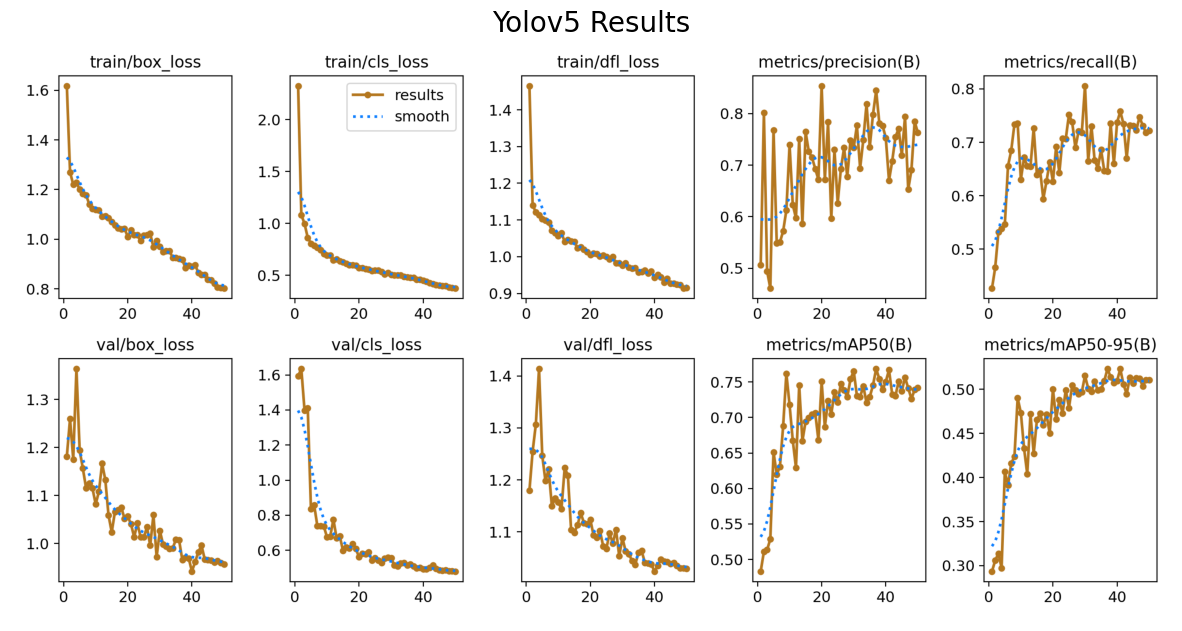

In [21]:
import cv2
import matplotlib.pyplot as plt 
import os 
# Defining Results' paths
v5_results_path=r'E:\Diploma\Machine Learning\AMIT Final Project\Dataset\Results4_V5\results.png'

# Yolov5 Results plotting
v5_results=cv2.imread(v5_results_path)
plt.figure(figsize=(15,15))
plt.imshow(v5_results)
plt.title('Yolov5 Results',fontsize=20)
plt.axis('off')
plt.show()

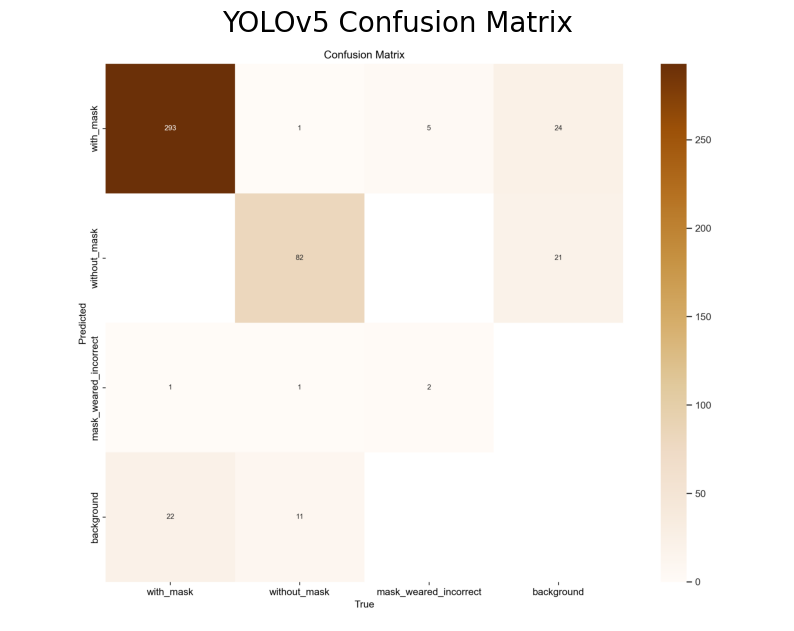

In [24]:
import cv2
import matplotlib.pyplot as plt 
import os 
# Defining Results' paths
v5_conf_mat_path=r'E:\Diploma\Machine Learning\AMIT Final Project\Dataset\Results4_V5\confusion_matrix.png'

# Yolov5 Results plotting

v5_conf_mat=cv2.imread(v5_conf_mat_path)

plt.figure(figsize=(10,10))
plt.imshow(v5_conf_mat)
plt.title('YOLOv5 Confusion Matrix',fontsize=20)
plt.axis('off')
plt.show()

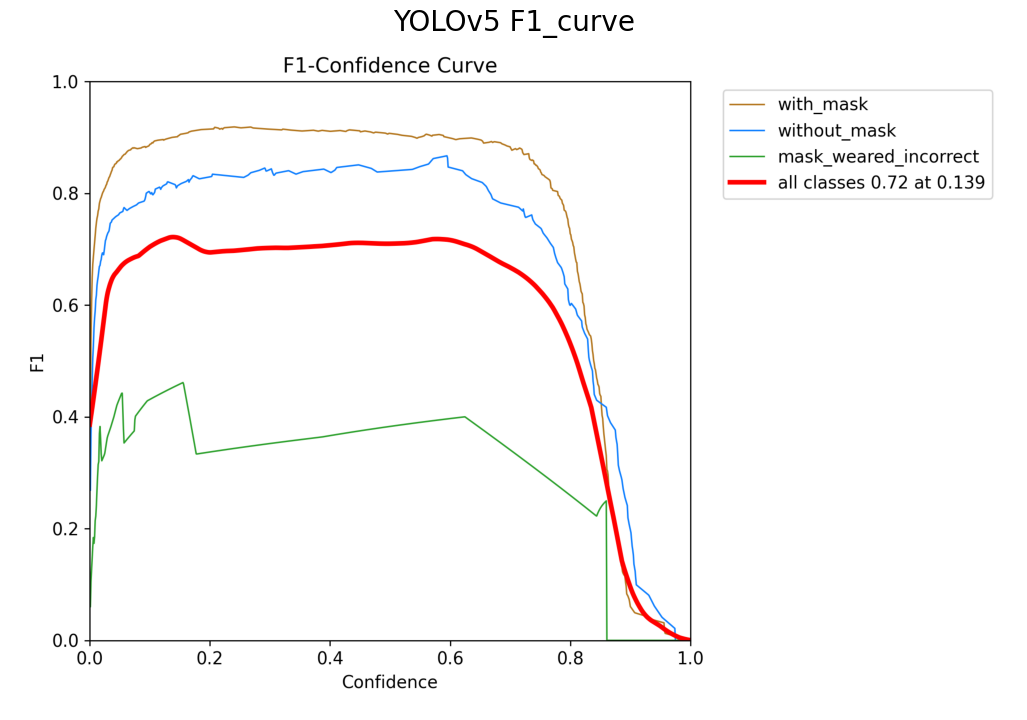

In [28]:
import cv2
import matplotlib.pyplot as plt 
import os 
# Defining Results' paths
v5_F1_curve_path=r'E:\Diploma\Machine Learning\AMIT Final Project\Dataset\Results4_V5\F1_curve.png'

# Yolov5 Results plotting

v5_F1_curve=cv2.imread(v5_F1_curve_path)

plt.figure(figsize=(13,13))
plt.imshow(v5_F1_curve)
plt.title('YOLOv5 F1_curve',fontsize=20)
plt.axis('off')
plt.show()

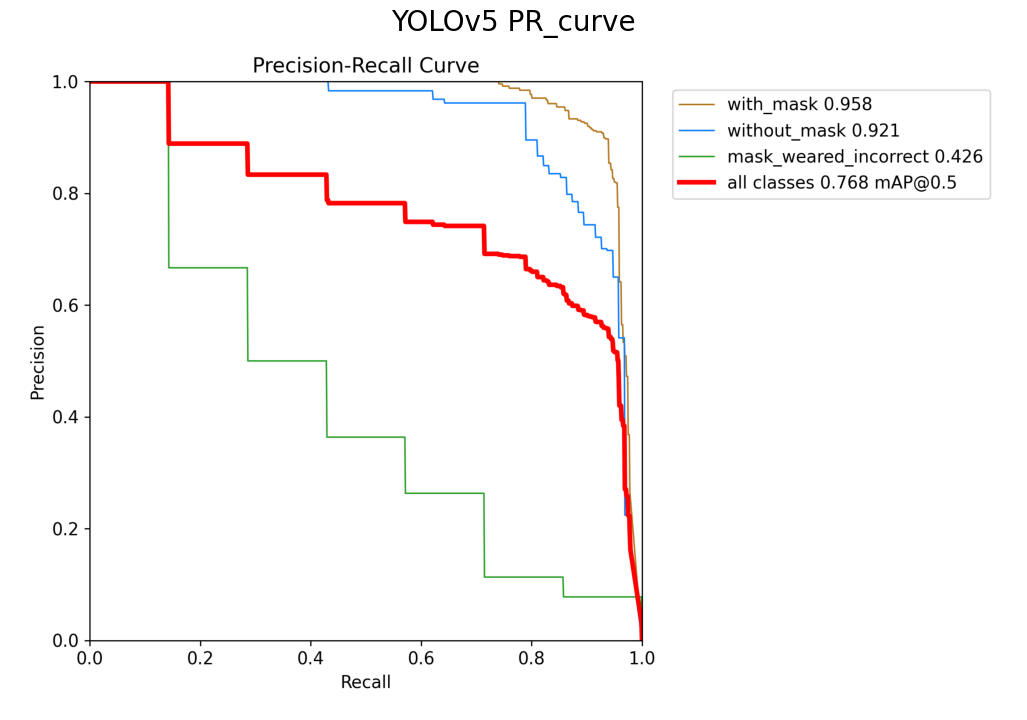

In [29]:
import cv2
import matplotlib.pyplot as plt 
import os 
# Defining Results' paths
v5_PR_curve_path=r'E:\Diploma\Machine Learning\AMIT Final Project\Dataset\Results4_V5\PR_curve.png'

# Yolov5 Results plotting

v5_PR_curve=cv2.imread(v5_PR_curve_path)

plt.figure(figsize=(13,13))
plt.imshow(v5_PR_curve)
plt.title('YOLOv5 PR_curve',fontsize=20)
plt.axis('off')
plt.show()

### 4.3 Drawing Results Graphs of Yolov8n

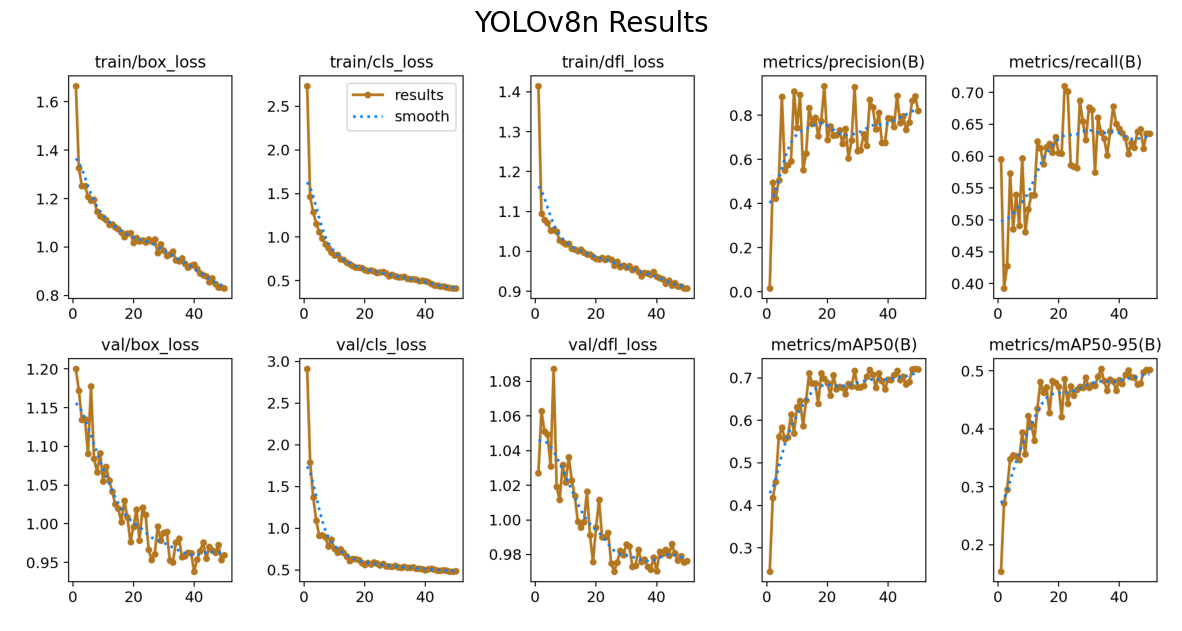

In [32]:
# Defining Results' paths
v8n_results_path=r'E:\Diploma\Machine Learning\AMIT Final Project\Dataset\Results5_V8n\results.png'

# Yolov8n Results plotting

v8n_results=cv2.imread(v8n_results_path)

plt.figure(figsize=(15,15))
plt.imshow(v8n_results)
plt.title('YOLOv8n Results',fontsize=20)
plt.axis('off')
plt.show()

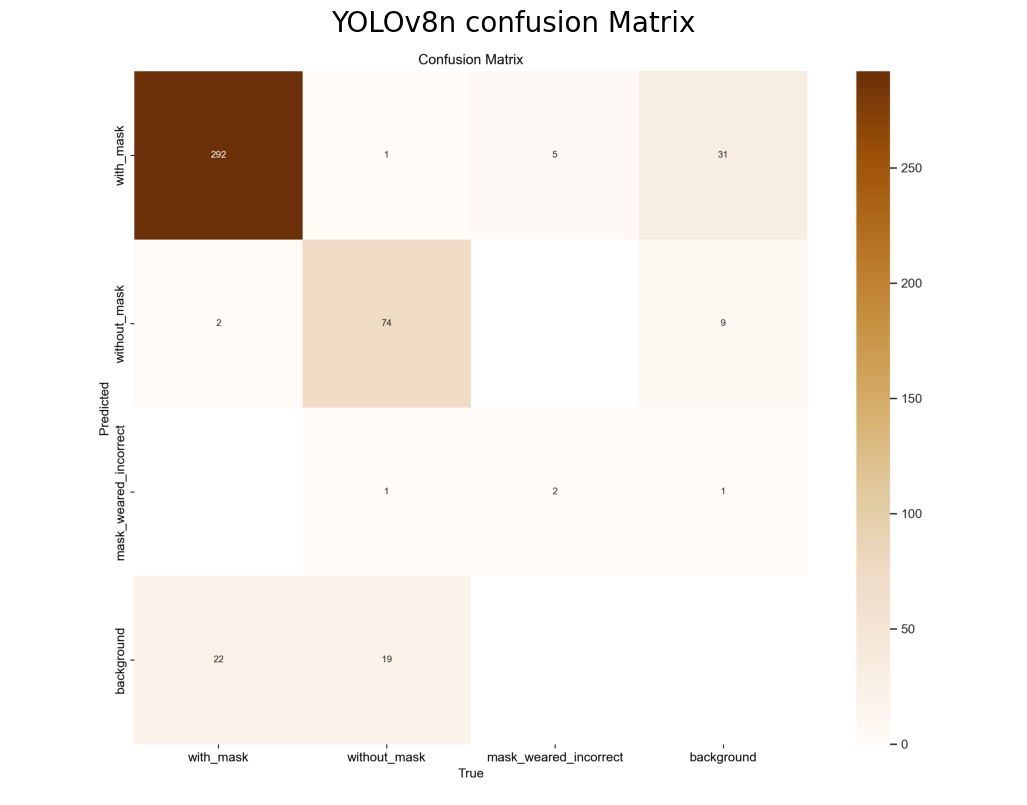

In [34]:
# Defining Results' paths
v8n_conf_mat_path=r'E:\Diploma\Machine Learning\AMIT Final Project\Dataset\Results5_V8n\confusion_matrix.png'

# Yolov8n Results plotting

v8n_conf_mat=cv2.imread(v8n_conf_mat_path)

plt.figure(figsize=(13,13))
plt.imshow(v8n_conf_mat)
plt.title('YOLOv8n confusion Matrix',fontsize=20)
plt.axis('off')
plt.show()

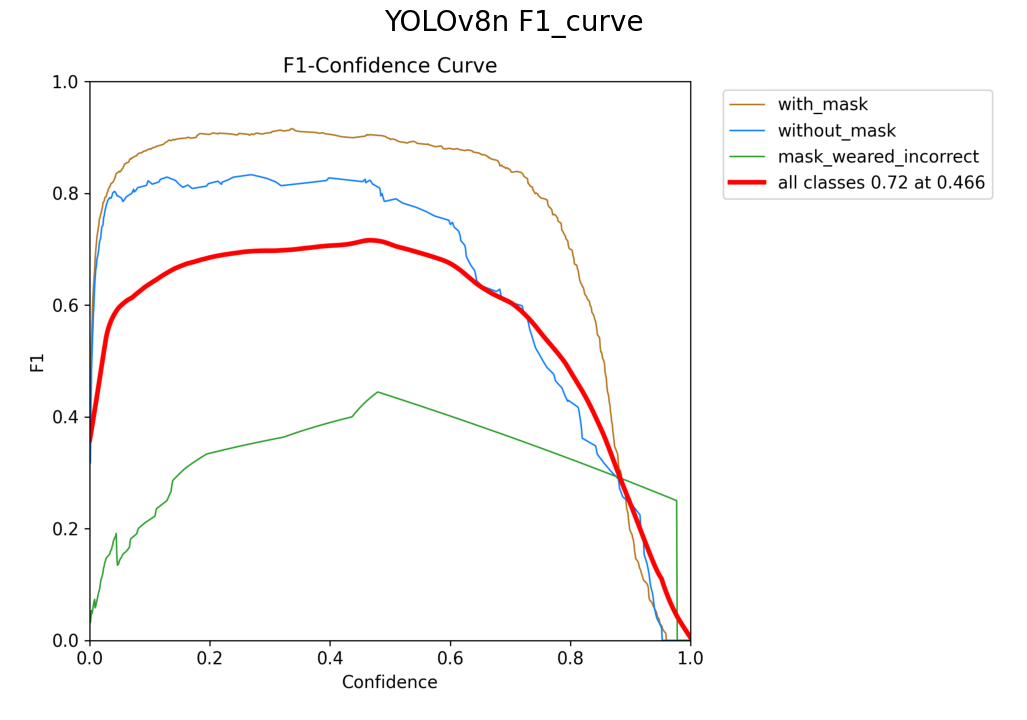

In [ ]:
# Defining Results' paths
v8n_F1_curve_path=r'E:\Diploma\Machine Learning\AMIT Final Project\Dataset\Results5_V8n\F1_curve.png'

# Yolov8n Results plotting

v8n_F1_curve=cv2.imread(v8n_F1_curve_path)

plt.figure(figsize=(13,13))
plt.imshow(v8n_F1_curve)
plt.title('YOLOv8n F1_curve',fontsize=20)
plt.axis('off')
plt.show()

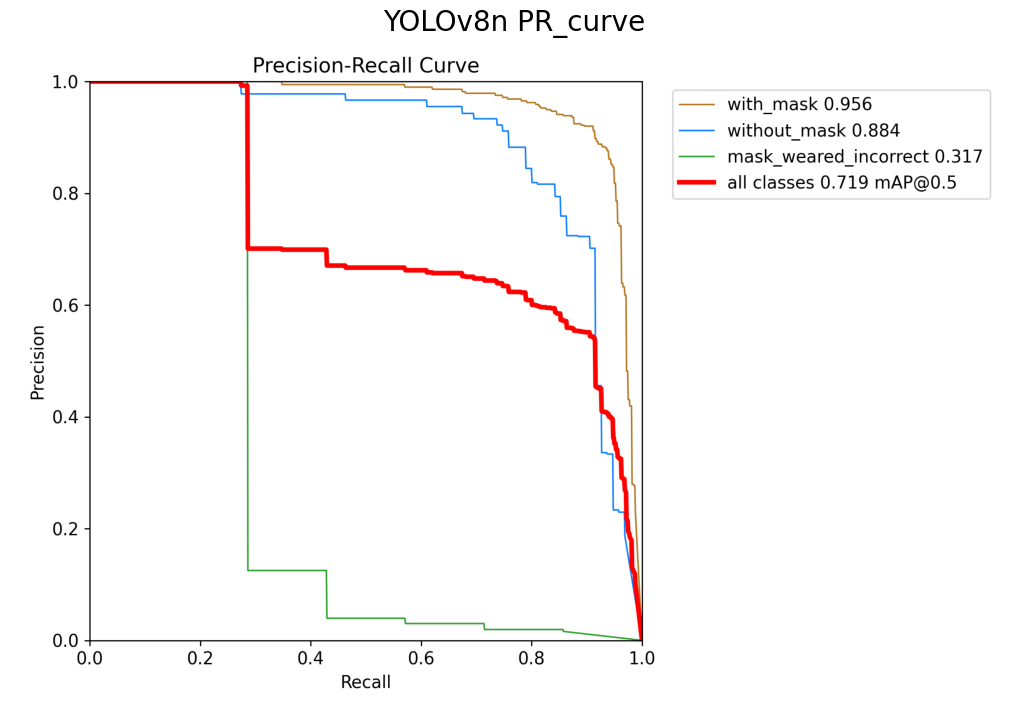

In [37]:
# Defining Results' paths
v8n_PR_curve_path=r'E:\Diploma\Machine Learning\AMIT Final Project\Dataset\Results5_V8n\PR_curve.png'

# Yolov8n Results plotting

v8n_PR_curve=cv2.imread(v8n_PR_curve_path)

plt.figure(figsize=(13,13))
plt.imshow(v8n_PR_curve)
plt.title('YOLOv8n PR_curve',fontsize=20)
plt.axis('off')
plt.show()

### 4.4 Drawing Results Graphs of Yolov8s

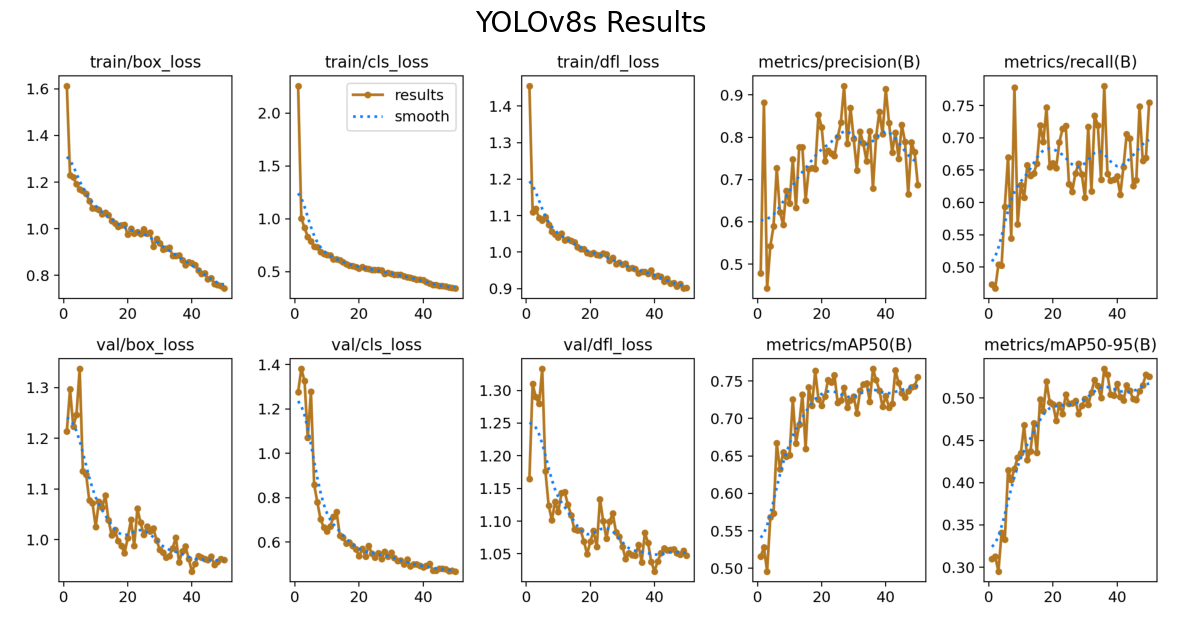

In [40]:
# Defining Results' paths
v8s_results_path=r'E:\Diploma\Machine Learning\AMIT Final Project\Dataset\Results6_V8s\results.png'

# Yolov8s Results plotting

v8s_results=cv2.imread(v8s_results_path)

plt.figure(figsize=(15,15))
plt.imshow(v8s_results)
plt.title('YOLOv8s Results',fontsize=20)
plt.axis('off')
plt.show()

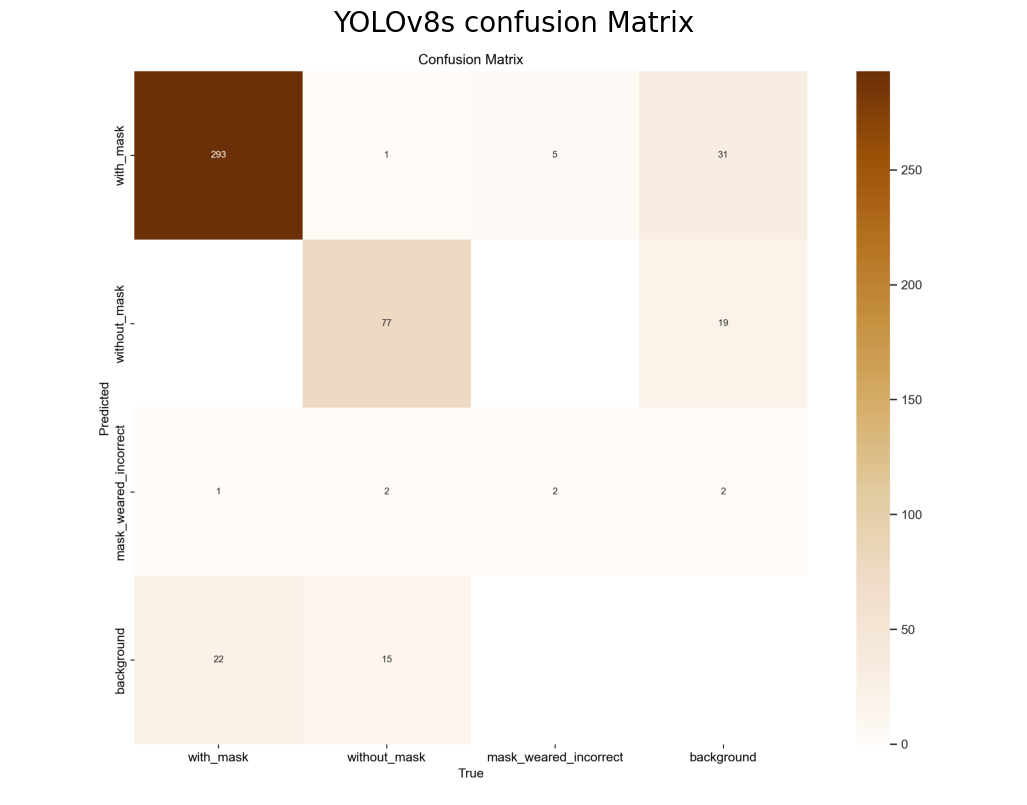

In [41]:
# Defining Results' paths
v8s_conf_mat_path=r'E:\Diploma\Machine Learning\AMIT Final Project\Dataset\Results6_V8s\confusion_matrix.png'

# Yolov8s Results plotting

v8s_conf_mat=cv2.imread(v8s_conf_mat_path)

plt.figure(figsize=(13,13))
plt.imshow(v8s_conf_mat)
plt.title('YOLOv8s confusion Matrix',fontsize=20)
plt.axis('off')
plt.show()

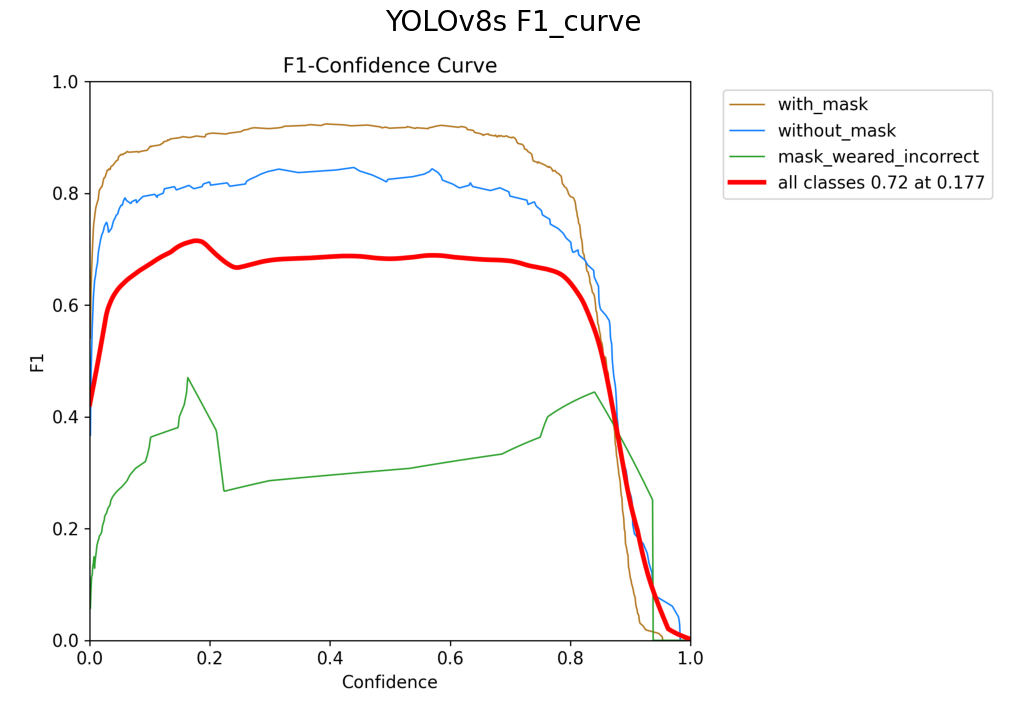

In [42]:
# Defining Results' paths
v8s_F1_curve_path=r'E:\Diploma\Machine Learning\AMIT Final Project\Dataset\Results6_V8s\F1_curve.png'

# Yolov8s Results plotting

v8s_F1_curve=cv2.imread(v8s_F1_curve_path)

plt.figure(figsize=(13,13))
plt.imshow(v8s_F1_curve)
plt.title('YOLOv8s F1_curve',fontsize=20)
plt.axis('off')
plt.show()

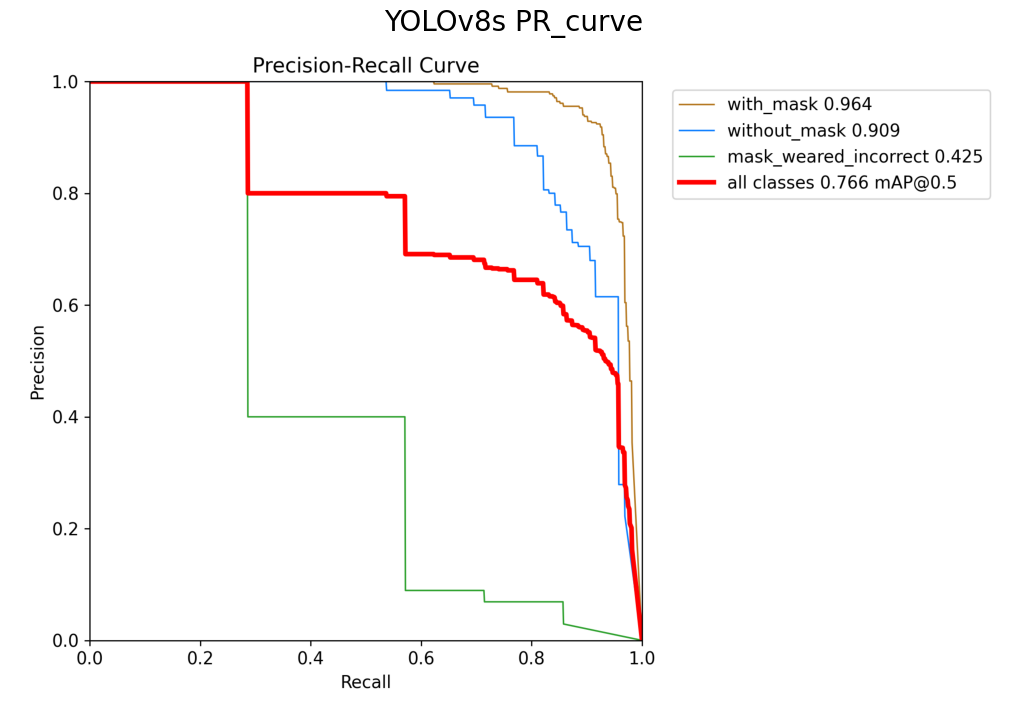

In [43]:
# Defining Results' paths
v8s_PR_curve_path=r'E:\Diploma\Machine Learning\AMIT Final Project\Dataset\Results6_V8s\PR_curve.png'

# Yolov8s Results plotting

v8s_PR_curve=cv2.imread(v8s_PR_curve_path)

plt.figure(figsize=(13,13))
plt.imshow(v8s_PR_curve)
plt.title('YOLOv8s PR_curve',fontsize=20)
plt.axis('off')
plt.show()

(-0.5, 2249.5, 1499.5, -0.5)

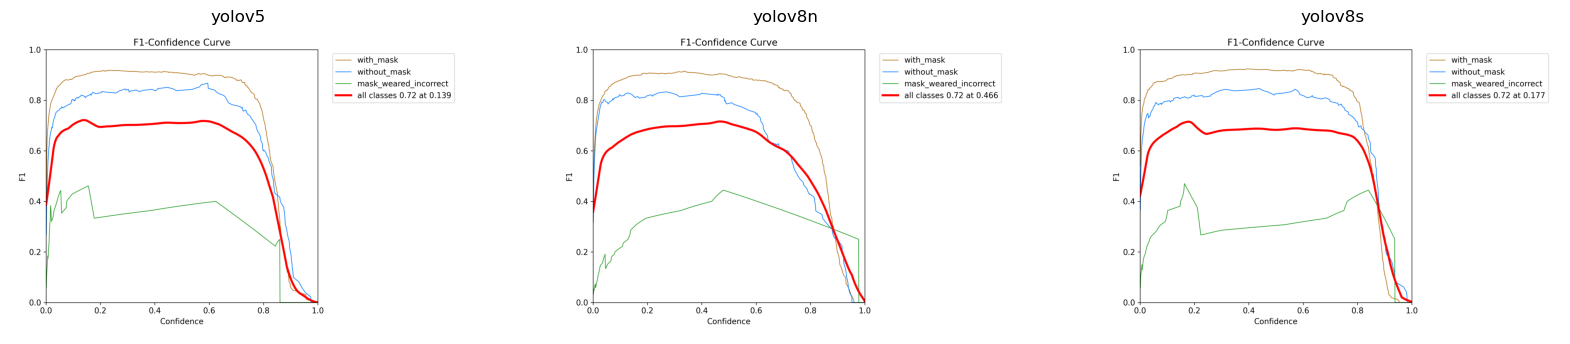

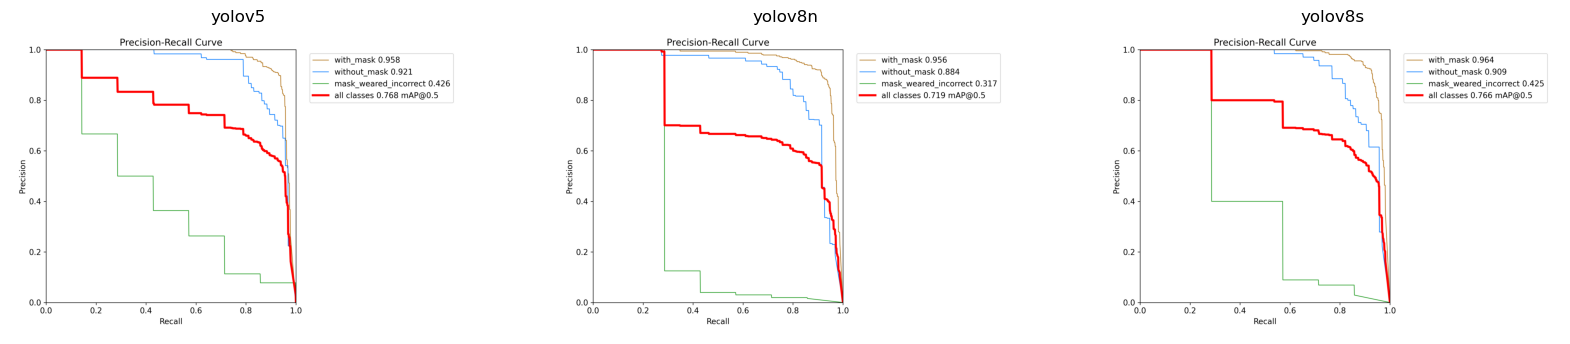

In [60]:
# Plotting F1_curves
plt.figure(figsize=(20,20))

plt.subplot(1,3,1)
plt.imshow(v5_F1_curve)
plt.title('yolov5')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(v8n_F1_curve)
plt.title('yolov8n')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(v8s_F1_curve)
plt.title('yolov8s')
plt.axis('off')

# Plotting PR_curves
plt.figure(figsize=(20,20))

plt.subplot(1,3,1)
plt.imshow(v5_PR_curve)
plt.title('yolov5')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(v8n_PR_curve)
plt.title('yolov8n')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(v8s_PR_curve)
plt.title('yolov8s')
plt.axis('off')
